In [3]:
import ml_collections
import copy
import numpy as np
import matplotlib.pyplot as plt
import ml_collections
import yaml
from tqdm import tqdm
import os
import torch
import torch.nn as nn
from os import path as pt

from src.evaluations.evaluations import fake_loader, full_evaluation
from src.utils import get_experiment_dir, set_seed, init_weights, save_obj
from torch.utils.data import DataLoader, TensorDataset
from src.baselines.models import GENERATORS, get_trainer
from src.baselines.base import BaseTrainer

## Load time series data

In [20]:
data = torch.load('./data/ref_data.pt')
print(data.shape)
print(data[:10,:,1 ])

torch.Size([20000, 20, 4])
tensor([[0.0795, 0.0880, 0.0802, 0.1118, 0.1112, 0.3284, 0.1423, 0.0598, 0.1595,
         0.0534, 0.0702, 0.0442, 0.0479, 0.0349, 0.0236, 0.0259, 0.0481, 0.0400,
         0.0377, 0.0224],
        [0.0569, 0.0598, 0.0838, 0.0721, 0.0912, 0.1180, 0.1294, 0.0907, 0.0871,
         0.0734, 0.1099, 0.1183, 0.0709, 0.0902, 0.0671, 0.0417, 0.0522, 0.0405,
         0.0667, 0.0806],
        [0.1010, 0.0841, 0.0731, 0.0860, 0.1204, 0.1163, 0.1563, 0.0930, 0.0854,
         0.0754, 0.0931, 0.0942, 0.1265, 0.0904, 0.0869, 0.0824, 0.0555, 0.0372,
         0.0445, 0.0572],
        [0.0870, 0.1520, 0.1221, 0.1252, 0.1288, 0.1932, 0.0988, 0.1375, 0.1222,
         0.0785, 0.1269, 0.1593, 0.2040, 0.2430, 0.1597, 0.1497, 0.1324, 0.1055,
         0.1085, 0.0817],
        [0.1311, 0.1411, 0.1850, 0.1653, 0.1381, 0.1303, 0.1551, 0.1647, 0.2409,
         0.2273, 0.1353, 0.1470, 0.2058, 0.2474, 0.2410, 0.1625, 0.2041, 0.2772,
         0.0937, 0.1579],
        [0.1367, 0.1279, 0.1387, 

# Plot samples of real time series

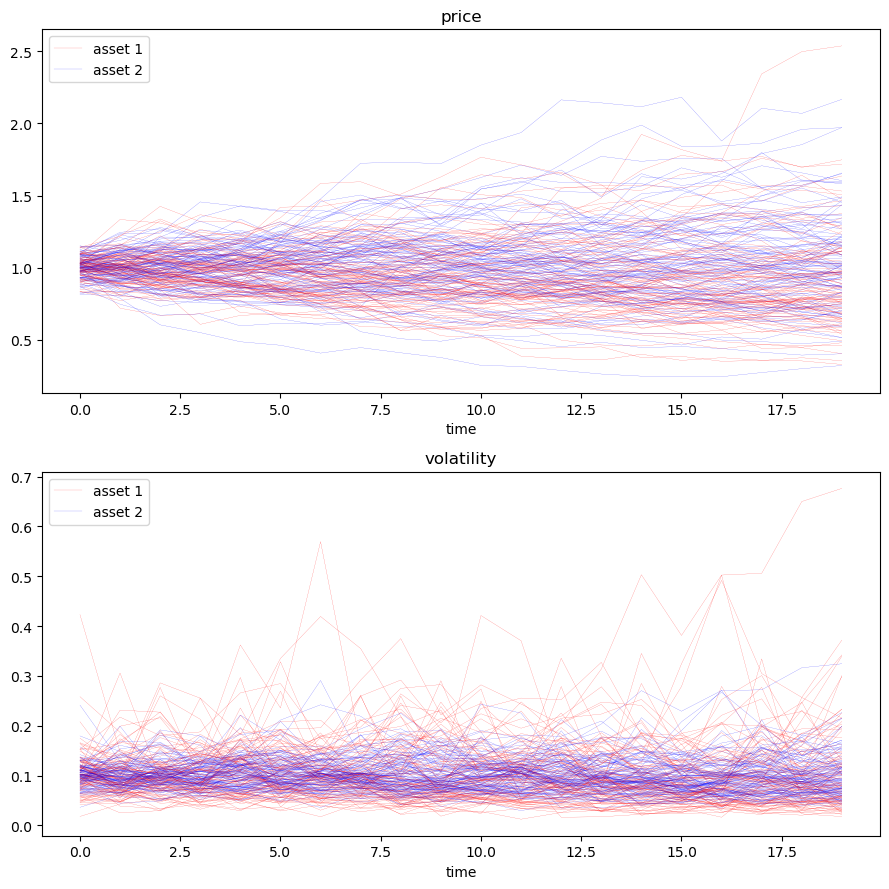

In [21]:
#fig = plt.figure(layout='constrained', figsize=(10, 4))
fig, axs = plt.subplots(2, figsize=(9,9))
y_label = ['price', 'volatility']

for i in range(2):
    for j in range(100):
        axs[i].plot(data[j,:,i].T.cpu(), c = 'red', linewidth = 0.1, label = 'asset 1' if j == 0 else None)
        axs[i].plot(data[j,:,2+i].T.cpu(), c = 'blue', linewidth = 0.1, label = 'asset 2'if j == 0 else None)
        axs[i].set_title(y_label[i])
        axs[i].set_xlabel('time')
    axs[i].legend()
fig.tight_layout()
plt.show()

## Regime-switching pattern

In [22]:
x = data[:,-1, 0]
print(x.shape)
print(x[:10])

torch.Size([20000])
tensor([1.3749, 1.3465, 0.5832, 1.0079, 2.5363, 0.6480, 1.5063, 0.8924, 0.7733,
        0.4809])


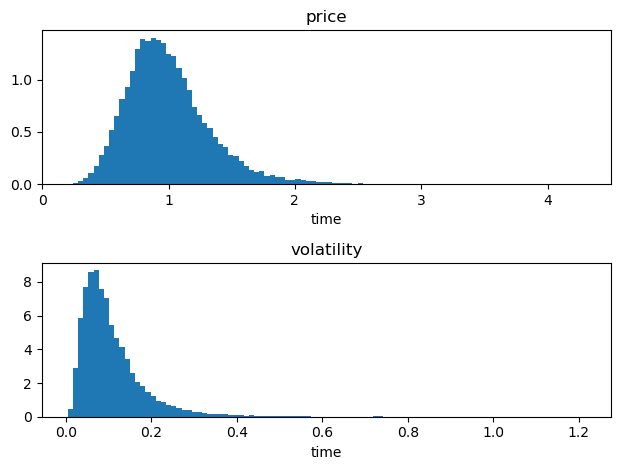

In [23]:
#fig = plt.figure(layout='constrained', figsize=(10, 4))
fig, axs = plt.subplots(2)
y_label = ['price', 'volatility']

for i in range(2):
    axs[i].hist(data[:,-1, i].cpu(), bins = 100, density = True)
    axs[i].set_title(y_label[i])
    axs[i].set_xlabel('time')
fig.tight_layout()
plt.show()

# Generative models for time series generation

In [4]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
    
set_seed(config.seed)

if (config.device ==
        "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:0"}, allow_val_change=True)
else:
    config.update({"device": "cpu"}, allow_val_change=True)

# Load the dataset
training_set = TensorDataset(
        torch.load(config.data_dir + 'ref_data.pt').to(config.device).to(torch.float))

train_dl = DataLoader(
    training_set,
    batch_size=config.batch_size,
    shuffle=True
)

config.input_dim = training_set[0][0].shape[-1]

## Sample model based on LSTM

In [32]:
# Sample model based on LSTM
class GeneratorBase(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GeneratorBase, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.input_dim = input_dim
        self.output_dim = output_dim

    # @abstractmethod
    def forward_(self, batch_size: int, n_lags: int, device: str):
        """ Implement here generation scheme. """
        # ...
        pass

    def forward(self, batch_size: int, n_lags: int, device: str):
        x = self.forward_(batch_size, n_lags, device)
        x = self.pipeline.inverse_transform(x)
        return x


class LSTMGenerator(GeneratorBase):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int, n_layers: int, init_fixed: bool = True):
        super(LSTMGenerator, self).__init__(input_dim, output_dim)
        # LSTM
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                           num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim, bias=True)
        self.linear.apply(init_weights)
        # neural network to initialise h0 from the LSTM
        # we put a tanh at the end because we are initialising h0 from the LSTM, that needs to take values between [-1,1]

        self.init_fixed = init_fixed

    def forward(self, batch_size: int, n_lags: int, device: str, condition=None, z=None) -> torch.Tensor:
        if condition is not None:
            z = (0.1 * torch.randn(batch_size, n_lags,
                                   self.input_dim-condition.shape[-1])).to(device)  # cumsum(1)
            z[:, 0, :] *= 0  # first point is fixed
            z = z.cumsum(1)
            z = torch.cat([z, condition], dim=2)
        else:
            if z is None:
                z = (0.1 * torch.randn(batch_size, n_lags,
                                       self.input_dim)).to(device)  # cumsum(1)
            else:
                pass
            if self.init_fixed:
                h0 = torch.zeros(self.rnn.num_layers, batch_size,
                                 self.rnn.hidden_size).to(device)
            else:
                h0 = torch.randn(self.rnn.num_layers, batch_size, self.rnn.hidden_size).to(
                    device).requires_grad_()
            z[:, 0, :] *= 0
            z = z.cumsum(1)
        c0 = torch.zeros_like(h0)
        h1, _ = self.rnn(z, (h0, c0))
        x = self.linear(h1)

        assert x.shape[1] == n_lags
        return x
    
class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, n_layers: int, out_dim=1, return_seq=False):
        super(LSTMDiscriminator, self).__init__()
        self.input_dim = input_dim
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)
        self.return_seq = return_seq

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.return_seq:
            h = self.lstm(x)[0]
        else:
            h = self.lstm(x)[0][:, -1:]
        x = self.linear(h)
        return x    

## Define the training algorithm

In [33]:
class RCGANTrainer(BaseTrainer):
    def __init__(self, D, G, train_dl, config,
                 **kwargs):
        super(RCGANTrainer, self).__init__(
            G=G,
            G_optimizer=torch.optim.Adam(
                G.parameters(), lr=config.lr_G, betas=(0, 0.9)),
            **kwargs
        )

        self.config = config
        self.D_steps_per_G_step = config.D_steps_per_G_step
        self.D = D
        self.D_optimizer = torch.optim.Adam(
            D.parameters(), lr=config.lr_D, betas=(0, 0.9))  # Using TTUR

        self.train_dl = train_dl
        self.reg_param = 0
        self.losses_history

    def fit(self, device):
        self.G.to(device)
        self.D.to(device)

        for i in tqdm(range(self.n_gradient_steps)):
            self.step(device, i)

    def step(self, device, step):
        for i in range(self.D_steps_per_G_step):
            # generate x_fake
            condition = None
            x_real_batch = next(iter(self.train_dl))[0].to(device)
            with torch.no_grad():
                x_fake = self.G(batch_size=self.batch_size,
                                n_lags=self.config.n_lags, condition=condition, device=device)

            D_loss_real, D_loss_fake = self.D_trainstep(
                x_fake, x_real_batch)
            if i == 0:
                self.losses_history['D_loss_fake'].append(D_loss_fake)
                self.losses_history['D_loss_real'].append(D_loss_real)
                self.losses_history['D_loss'].append(D_loss_fake + D_loss_real)
        G_loss = self.G_trainstep(x_real_batch, device, step)

    def G_trainstep(self, x_real, device, step):
        condition = None
        x_fake = self.G(batch_size=self.batch_size,
                        n_lags=self.config.n_lags, condition=condition, device=device)
        self.toggle_grad(self.G, True)
        self.G.train()
        self.G_optimizer.zero_grad()
        d_fake = self.D(x_fake)
        self.D.train()
        G_loss = self.compute_loss(d_fake, 1.)
        G_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.G.parameters(), 10)
        self.losses_history['G_loss'].append(G_loss)
        self.G_optimizer.step()

        return G_loss.item()

    def D_trainstep(self, x_fake, x_real):
        self.toggle_grad(self.D, True)
        self.D.train()
        self.D_optimizer.zero_grad()

        # On real data
        x_real.requires_grad_()
        d_real = self.D(x_real)
        dloss_real = self.compute_loss(d_real, 1.)

        # On fake data
        x_fake.requires_grad_()
        d_fake = self.D(x_fake)
        dloss_fake = self.compute_loss(d_fake, 0.)

        # Compute regularizer on fake / real
        dloss = dloss_fake + dloss_real

        dloss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.D.parameters(), 10)
        # Step discriminator params
        self.D_optimizer.step()

        # Toggle gradient to False
        self.toggle_grad(self.D, False)

        return dloss_real.item(), dloss_fake.item()

    def compute_loss(self, d_out, target):
        targets = d_out.new_full(size=d_out.size(), fill_value=target)
        loss = torch.nn.BCELoss()(torch.nn.Sigmoid()(d_out), targets)
        return loss

    def save_model_dict(self):
        save_obj(self.G.state_dict(), pt.join(
            self.config.exp_dir, 'generator_state_dict.pt'))

## Initialize the generator, discriminator and the trainer

In [34]:
D_out_dim = 1
return_seq = True

generator = LSTMGenerator(
    input_dim=config.G_input_dim, hidden_dim=config.G_hidden_dim, output_dim=config.input_dim,
    n_layers=config.G_num_layers, init_fixed=config.init_fixed)
discriminator = LSTMDiscriminator(
    input_dim=config.input_dim, hidden_dim=config.D_hidden_dim, out_dim=D_out_dim, n_layers=config.D_num_layers,
    return_seq=return_seq)
    # print('GENERATOR:', generator)
    # print('DISCRIMINATOR:', discriminator)

trainer = RCGANTrainer(G=generator, D=discriminator,
                    train_dl=train_dl, batch_size=config.batch_size, n_gradient_steps=config.steps,
                    config=config)

# Create model directory and instantiate config.path
get_experiment_dir(config)

## Model training

In [36]:
# Model training
trainer.fit(config.device)
trainer.save_model_dict()

100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


## Model evaluation

In [37]:
# Model evaluation
generator = LSTMGenerator(
    input_dim=config.G_input_dim, hidden_dim=config.G_hidden_dim, output_dim=config.input_dim, n_layers=config.G_num_layers, init_fixed=config.init_fixed)
generator.load_state_dict(torch.load(pt.join(
    config.exp_dir, 'generator_state_dict.pt')))

# Use ref data to produce res_data
test_set = TensorDataset(
    torch.load(config.data_dir + 'res_data.pt').to(config.device).to(torch.float))

test_dl = DataLoader(
    test_set,
    batch_size=config.batch_size,
    shuffle=True
)

fake_test_dl = fake_loader(generator, num_samples=len(test_dl.dataset),
                           n_lags=config.n_lags, batch_size=test_dl.batch_size, algo=config.algo
                           )

res_dict = full_evaluation(test_dl, fake_test_dl, config)
for k, v in res_dict.items():
    print(k, v)

Accuracy of the network on the 800 test samples: 100.0
predictor(
  (rnn): LSTM(4, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=8, bias=True)
)
Predictive Score 0.3871322045326233
Discriminative Score 0.5
Marginal Score 1.479138
Correlation Score 3.0143619
Auto-correlation Score 0.9483415
Covariance Score 0.007179107
